<a href="https://colab.research.google.com/github/hrithikwel8/Rossmann_Sales_Prediction/blob/main/Ameen_Rossmann_Sales_Prediction_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Sales Prediction : Predicting sales of a major store chain Rossmann</u></b>

## <b> Problem Description </b>

### Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.

### You are provided with historical sales data for 1,115 Rossmann stores. The task is to forecast the "Sales" column for the test set. Note that some stores in the dataset were temporarily closed for refurbishment.

## <b> Data Description </b>

### <b>Rossmann Stores Data.csv </b> - historical data including Sales
### <b>store.csv </b> - supplemental information about the stores


### <b><u>Data fields</u></b>
### Most of the fields are self-explanatory. The following are descriptions for those that aren't.

* #### Id - an Id that represents a (Store, Date) duple within the test set
* #### Store - a unique Id for each store
* #### Sales - the turnover for any given day (this is what you are predicting)
* #### Customers - the number of customers on a given day
* #### Open - an indicator for whether the store was open: 0 = closed, 1 = open
* #### StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
* #### SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
* #### StoreType - differentiates between 4 different store models: a, b, c, d
* #### Assortment - describes an assortment level: a = basic, b = extra, c = extended
* #### CompetitionDistance - distance in meters to the nearest competitor store
* #### CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
* #### Promo - indicates whether a store is running a promo on that day
* #### Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
* #### Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
* #### PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

In [ ]:
# Importing the libraries
import numpy as np
import pandas as pd
from datetime import date, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
store_data_df = pd.read_csv('/content/drive/MyDrive/AlmaBetter Data Science/CAPSTONE PROJECT-2/Retail Sales Prediction/Data & Resources/Rossmann Stores Data.csv')
store_df = pd.read_csv('/content/drive/MyDrive/AlmaBetter Data Science/CAPSTONE PROJECT-2/Retail Sales Prediction/Data & Resources/store.csv')

**Checking the assumptions of Linear Regression**

We are using linear regression model so, we need to check 4 basic assumptions of linear regression.

1. There need to be linear relationship between independent and dependent variables
2. The sum of residuals should be near 0
3. There should not be multicollinearity
4. These should not be heteroscedasticity

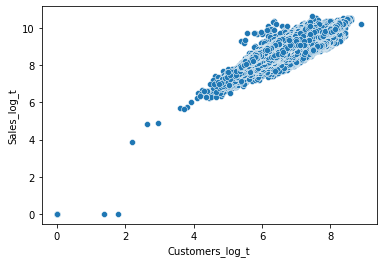

In [ ]:
# Plotting the relationship between sales and customer
sns.scatterplot(data=sales_df,x='Customers_log_t',y='Sales_log_t')

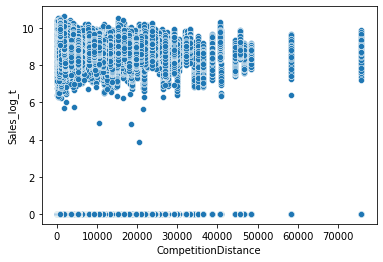

In [ ]:
# Plotting the relationship between Sales and Competition Distance
sns.scatterplot(data=sales_df,x='CompetitionDistance',y='Sales_log_t')

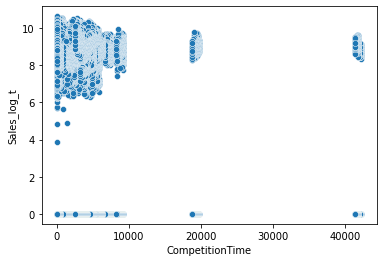

In [ ]:
# Plotting the relationship between Sales and Compition Open Since Number Of Days
sns.scatterplot(data=sales_df,x='CompetitionTime',y='Sales_log_t')

In [ ]:
# Checking the mean of Residuals
sum(y_pred-y_test)/ len(sales_df)

-0.0007064634619246783

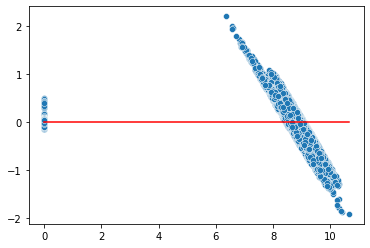

In [ ]:
# Checking Homoscedasticity
error_terms = y_pred-y_test
plot = sns.scatterplot(x=y_test,y=error_terms)
# plot.map_dataframe(plot_hline,y=0)
plt.plot([0,max(y_test)], [0,0], 'r-')

**Predicting Sales for next six weeks**

Now that we have linear regression models that performing well. we need to predict Sales for next 6 weeks in Advance.

To do that we need independent variables data to create X_test data set.
So we need to generate data for X_test and then we can use the data for prediction.

In [ ]:
train_data_independent_variables.head()

,Store,DayOfWeek,Open,Promo,SchoolHoliday,public_holiday,easter_holiday,christmas,Month,Day,CompetitionDistance,Store_Type,Assortment_Level,Promo_cont,CompetitionTime
504524,554,1,1,0,0,0,0,0,2,23,1200.0,3,3,0,0
246042,271,5,1,0,1,0,0,0,8,15,420.0,1,1,0,0
657094,722,5,1,1,1,0,0,0,8,2,50.0,1,1,0,0
415179,455,2,1,1,0,0,0,0,7,2,7660.0,4,3,0,1035
101053,111,4,1,0,0,0,0,0,1,16,7890.0,4,3,1,0


Our models are trained train_data_independent_variables dataset so we need to generate data with columns in the same order to predict sales on the generated data.

In [ ]:
# these functions uses train_data_independent_variables dataframe as reference dataframe
# function to check if there is a holiday on given date and holiday name
def get_holidays(ref_date, holiday):
  # check reference dataset for holidays
  # get first instance of each month and day
  df_group = train_data_independent_variables.groupby(['Month','Day']).first()
  # get array of values for given holiday
  val_array = df_group[holiday].values
  # convert given date to array of day_of_year
  day_of_year = ref_date.apply(lambda x: x.timetuple().tm_yday).values
  # return the array of holiday values for given date
  return val_array[day_of_year - 1] # remove 1 as array index start from 0

In [ ]:
# function to check if there is school holiday on given date
def get_school_holidays(ref_date):
  # schools have holidays on sunday and any of other holidays or have vacations
  # first get holidays as sundays
  sundays = ref_date.apply(lambda x: 1 if x.weekday() == 6 else 0) 
  # get school holidays from reference dataset
  holidays = get_holidays(ref_date, 'SchoolHoliday')
  school_holidays = []
  # create a loop to get school holidays
  for i in range(len(ref_date)):
    # if it's sunday then it's school holiday else get school holiday from refence dataset
    if sundays[i] == 1:
      school_holidays.append(1)
    else:
      school_holidays.append(holidays[i])
  return school_holidays

In [ ]:
# function to get reference value of given variable from the reference data set
def get_ref_value(store_ids, var_name):
  # first group reference dataset by store and get first instance of given variable as series
  # then convert it to array of values
  first_inst = train_data_independent_variables.groupby(['Store']).first()[var_name].values
  # now get array of result values by indexing from dataset
  return first_inst[store_ids - 1] # remove 1 as array index start from 0

In [ ]:
# function to get promo_cont from reference dataset
def get_promo_cont(store_ids, months):
  # first group reference dataset by store and month and get first instance of each group
  # then convert it to array of values for variable promo_cont
  values = train_data_independent_variables.groupby(['Store','Month']).first()['Promo_cont'].values
  # now get array of indices to get promo_count value
  indices = []
  month_values = months.values
  for index, id in enumerate(store_ids):
    # we have used groupby first on store and then months so values are arranged first by store then month
    # so we can get index by first multiplying store id with 12(total months) and then adding month value for
    # a particular store id 
    index = ((id - 1)*12) + month_values[index] - 1  # remove 1 as array index start from 0
    indices.append(index)
  # return prmo_count values as array
  return values[indices]

In [ ]:
# function to get values for variable Open from reference dataset
def get_open(dataset):
  # we can calculate store being with probability values calculated from reference dataset
  # from EDA we can see that most stores are closed on public holiday, easter holiday and christmas
  # first calculate probabilities for each store being open on holidays
  store_open_public_holiday = train_data_independent_variables.groupby(['Store','public_holiday']).sum().iloc[1::2]['Open'].values
  store_total_public_holiday = train_data_independent_variables.groupby(['Store','public_holiday']).count().iloc[1::2]['Open'].values
  open_prob_public_holiday = store_open_public_holiday / store_total_public_holiday
  # easter holiday
  store_open_easter_holiday = train_data_independent_variables.groupby(['Store','easter_holiday']).sum().iloc[1::2]['Open'].values
  store_total_easter_holiday = train_data_independent_variables.groupby(['Store','easter_holiday']).count().iloc[1::2]['Open'].values
  open_prob_easter_holiday = store_open_easter_holiday / store_total_easter_holiday
  # christmas
  store_open_christmas = train_data_independent_variables.groupby(['Store','christmas']).sum().iloc[1::2]['Open'].values
  store_total_christmas = train_data_independent_variables.groupby(['Store','christmas']).count().iloc[1::2]['Open'].values
  open_prob_christmas = store_open_christmas / store_total_christmas
  # sundays
  store_open_sundays = train_data_independent_variables.groupby(['Store','DayOfWeek']).sum().iloc[6::7]['Open'].values
  store_total_sundays = train_data_independent_variables.groupby(['Store','DayOfWeek']).count().iloc[6::7]['Open'].values
  open_prob_sundays = store_open_sundays / store_total_sundays
  # non sundays
  store_open_days = train_data_independent_variables.groupby(['Store']).sum()['Open'].values - store_open_sundays
  store_total_days = train_data_independent_variables.groupby(['Store']).count()['Open'].values - store_total_sundays
  open_prob_days = store_open_days / store_total_days
  # create a list for open values
  open_val = []
  for i in range(len(dataset)):
    # get a random value from [0,1)
    rand = random.random()
    # get i'th observation from dataset
    observation = dataset.iloc[i]
    store_id = observation['Store'] - 1  # remove 1 as array index start from 0
    # if probability of store being open in holiday is higher than random number we mark store as open
    # first check for christmas
    if (int(observation['christmas']) == 1) and (open_prob_christmas[store_id] > rand):
      open_val.append(1)
    # check for easter
    elif (int(observation['easter_holiday']) == 1) and (open_prob_easter_holiday[store_id] > rand):
      open_val.append(1)
    # check for public holiday
    elif (int(observation['public_holiday']) == 1) and (open_prob_public_holiday[store_id] > rand):
      open_val.append(1)
    else:
      # check for sunday
      if int(observation['DayOfWeek']) == 7:
        if open_prob_sundays[store_id] > rand:
          open_val.append(1)
        else:
          open_val.append(0)
      else:  # check for other days
        if open_prob_days[store_id] > rand:
          open_val.append(1)
        else:
          open_val.append(0)
  return open_val

In [ ]:
# function to generate data for next 6 weeks from given starting date 
# this function uses train_data_independent_variables dataframe as reference dataframe
def generate_date_for_six_week(start_date):
  # Creating new dataframe to generate data
  new_df = pd.DataFrame()
  # Creating stores list for our new dataframe using for loop
  store_list = []
  # Creating date for next six weeks for new dataframe
  date_time = []
  for i in range(1, 1116):  # adding all the stores with id from 1 to 1115
    for j in range(42):  # days of 6 week = 6*7 = 42
      store_list.append(i)
      date_time.append(start_date + timedelta(j))
  # Adding the column Stores in our new dataframe
  new_df['Store'] = store_list
  # Adding the dates in our new dataframe
  new_df['Date_time'] = date_time
  # Adding day of week
  new_df['DayOfWeek'] = new_df['Date_time'].apply(lambda x: x.weekday()+1)  # add as weekday start from 0
  # add store open as 0 for now we will update it later
  new_df['Open'] = 0
  # create a list for promo offers
  stores_promo = []
  # create a loop to calculate probability for each store running promo
  for i in range(1, 1116):
    total_days = (split_date - first_date).days
    # get number of days current store running promo
    promo_days = len(train_data_independent_variables[(train_data_independent_variables['Store']==i) & (train_data_independent_variables['Promo']==1)])
    # calculate the probability of store running promo and add it to the list
    prob = promo_days / total_days
    # from the probability calculate if store running promo on given day or not
    for j in range(42):
      # if probability is higher than random number[0,1) then store will run promo
      if prob > (random.random()):
        stores_promo.append(1)
      else:
        stores_promo.append(0)
  # Adding Promo
  new_df['Promo'] = stores_promo
  # Add school holiday
  new_df['SchoolHoliday'] = get_school_holidays(new_df['Date_time'])
  # public_holiday, easter_holiday and christmas comes on same day and same month every year
  # so we can add these holidays from our reference dataset 
  new_df['public_holiday'] = get_holidays(new_df['Date_time'],'public_holiday')
  new_df['easter_holiday'] = get_holidays(new_df['Date_time'],'easter_holiday')
  new_df['christmas'] = get_holidays(new_df['Date_time'],'christmas')
  # Add Month and Day from the date
  new_df['Month'] = new_df['Date_time'].apply(lambda x: x.month)
  new_df['Day'] = new_df['Date_time'].apply(lambda x: x.day)
  # CompetitionDistance, CompetitionTime, Store_Type and Assortment_Level will be same as reference dataset for each store
  # so we can get the value for these variables from reference dataset
  new_df['CompetitionDistance'] = get_ref_value(new_df['Store'],'CompetitionDistance')
  new_df['Store_Type'] = get_ref_value(new_df['Store'],'Store_Type')
  new_df['Assortment_Level'] = get_ref_value(new_df['Store'],'Assortment_Level')
  # Promo_cont will run a month so we can get value from reference dataset for given month for each store
  new_df['Promo_cont'] = get_promo_cont(new_df['Store'],new_df['Month'])
  new_df['CompetitionTime'] = get_ref_value(new_df['Store'],'CompetitionTime')
  # update open values
  new_df['Open'] = get_open(new_df)
  return new_df

Now we have function to generate data we can get data for the last 6 weeks to check prediction of our model on the generated data.

In [ ]:
gen_df_test = generate_date_for_six_week(split_date + timedelta(1))
gen_df_test

,Store,Date_time,DayOfWeek,Open,Promo,SchoolHoliday,public_holiday,easter_holiday,christmas,Month,Day,CompetitionDistance,Store_Type,Assortment_Level,Promo_cont,CompetitionTime
0,1,2015-06-20,6,1,0,0,0,0,0,6,20,1270.0,3,1,0,2306
1,1,2015-06-21,7,0,1,1,0,0,0,6,21,1270.0,3,1,0,2306
2,1,2015-06-22,1,1,0,0,0,0,0,6,22,1270.0,3,1,0,2306
3,1,2015-06-23,2,1,0,0,0,0,0,6,23,1270.0,3,1,0,2306
4,1,2015-06-24,3,1,1,0,0,0,0,6,24,1270.0,3,1,0,2306
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46825,1115,2015-07-27,1,1,1,0,0,0,0,7,27,5350.0,4,3,0,0
46826,1115,2015-07-28,2,1,0,1,0,0,0,7,28,5350.0,4,3,0,0
46827,1115,2015-07-29,3,1,1,1,0,0,0,7,29,5350.0,4,3,0,0
46828,1115,2015-07-30,4,1,1,1,0,0,0,7,30,5350.0,4,3,0,0


The generated data is sorted by store and then date. So we need to sort the dependent variable to make sure predictions are in the right order.

In [ ]:
test_data_sorted = test_data.sort_values(by=['Store','Year','Month','Day'],ascending=True)
test_data_sorted

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,public_holiday,easter_holiday,christmas,Year,Month,Day,Sales_log_t,Customers_log_t,CompetitionDistance,Store_Type,Assortment_Level,Promo_cont,CompetitionTime
41,1,6,4097,494,1,0,0,0,0,0,2015,6,20,8.318254,6.204558,1270.0,3,1,0,2483
40,1,7,0,0,0,0,0,0,0,0,2015,6,21,0.000000,0.000000,1270.0,3,1,0,2484
39,1,1,3846,489,1,0,0,0,0,0,2015,6,22,8.255049,6.194405,1270.0,3,1,0,2485
38,1,2,3762,447,1,0,0,0,0,0,2015,6,23,8.232972,6.104793,1270.0,3,1,0,2486
37,1,3,3346,414,1,0,0,0,0,0,2015,6,24,8.115820,6.028279,1270.0,3,1,0,2487
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016271,1115,1,10712,608,1,1,1,0,0,0,2015,7,27,9.279213,6.411818,5350.0,4,3,0,0
1016270,1115,2,8093,500,1,1,1,0,0,0,2015,7,28,8.998878,6.216606,5350.0,4,3,0,0
1016269,1115,3,7661,473,1,1,1,0,0,0,2015,7,29,8.944028,6.161207,5350.0,4,3,0,0
1016268,1115,4,8405,502,1,1,1,0,0,0,2015,7,30,9.036701,6.220590,5350.0,4,3,0,0


Now we can create a test dataset from generated data and predict sales values in log transform and compare it with our previous prediction. This comparison gives us the accuracy of our data generating function.

In [ ]:
# get test dataset for generated data
X_test_gen = gen_df_test.drop(columns=['Date_time']).values
y_test_gen = test_data_sorted['Sales_log_t'].values
# scale the dataset to feed it in model
X_test_gen = scaler.transform(X_test_gen)

In [ ]:
# use stack model to predict the result
y_pred_gen = stack_predict(X_test_gen)

In [ ]:
# Evaluation metrics for Stack model
evaluation_metrics(y_test_gen , y_pred_gen, len(independent_variables))

Mean Squared Error : 2.75
Root Mean Squared Error : 2
Mean Absolute Error : 0.6
Mean Absolute Percentage Error : 9.47 %
R-Square : 0.71
Adjusted R-Square :  0.71


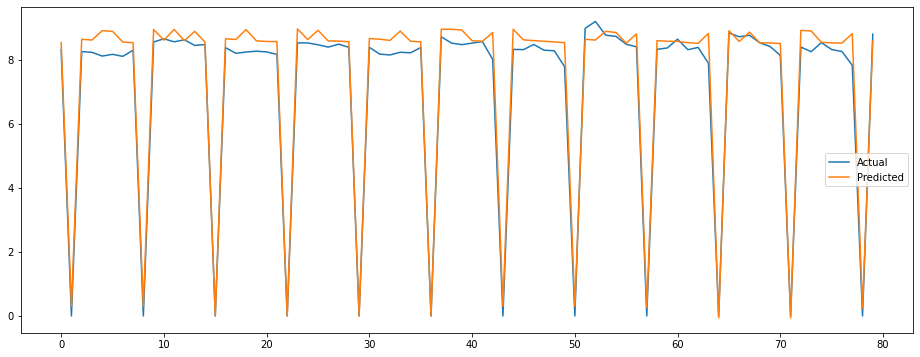

In [ ]:
# Plot first 80 observations between actual and predicted
plt.figure(figsize=(16,6))
plt.plot(y_test_gen[0:80])
plt.plot(y_pred_gen[0:80])
plt.legend(['Actual','Predicted'])
plt.show()

After checking generative function efficiency let's generate data for the next 6 weeks to predict sales for the problem statement.

In [ ]:
data_advance = generate_date_for_six_week(last_date + timedelta(1))
data_advance

,Store,Date_time,DayOfWeek,Open,Promo,SchoolHoliday,public_holiday,easter_holiday,christmas,Month,Day,CompetitionDistance,Store_Type,Assortment_Level,Promo_cont,CompetitionTime
0,1,2015-08-01,6,1,0,1,0,0,0,8,1,1270.0,3,1,0,2306
1,1,2015-08-02,7,0,1,1,0,0,0,8,2,1270.0,3,1,0,2306
2,1,2015-08-03,1,1,1,0,0,0,0,8,3,1270.0,3,1,0,2306
3,1,2015-08-04,2,0,0,0,0,0,0,8,4,1270.0,3,1,0,2306
4,1,2015-08-05,3,1,0,1,0,0,0,8,5,1270.0,3,1,0,2306
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46825,1115,2015-09-07,1,1,1,0,0,0,0,9,7,5350.0,4,3,1,0
46826,1115,2015-09-08,2,1,0,0,0,0,0,9,8,5350.0,4,3,1,0
46827,1115,2015-09-09,3,1,0,0,0,0,0,9,9,5350.0,4,3,1,0
46828,1115,2015-09-10,4,1,1,0,0,0,0,9,10,5350.0,4,3,1,0


In [ ]:
# get test dataset for generated data
X_test_gen_adv = data_advance.drop(columns=['Date_time']).values
# scale the dataset to feed it in model
X_test_gen_adv = scaler.transform(X_test_gen_adv)

In [ ]:
# use stack model to predict the result
y_pred_gen_adv = stack_predict(X_test_gen_adv)

We got out predictions but they are in log transform state, we need to convert them into proper sales value.

In [ ]:
# apply exponent function to convert log values to original Sales value
final_pred = np.exp(y_pred_gen_adv)
# total of Sales for next 6 week
total = int(sum(final_pred))
print('Total of Predicted Sales in next 6 week will be: ' + str(total))

Total of Predicted Sales in next 6 week will be: 250776406


In [ ]:
data_advance['Sales'] = final_pred.astype(np.int)
data_advance.head()

,Store,Date_time,DayOfWeek,Open,Promo,SchoolHoliday,public_holiday,easter_holiday,christmas,Month,Day,CompetitionDistance,Store_Type,Assortment_Level,Promo_cont,CompetitionTime,Sales
0,1,2015-08-01,6,1,0,1,0,0,0,8,1,1270.0,3,1,0,2306,5326
1,1,2015-08-02,7,0,1,1,0,0,0,8,2,1270.0,3,1,0,2306,1
2,1,2015-08-03,1,1,1,0,0,0,0,8,3,1270.0,3,1,0,2306,7918
3,1,2015-08-04,2,0,0,0,0,0,0,8,4,1270.0,3,1,0,2306,1
4,1,2015-08-05,3,1,0,1,0,0,0,8,5,1270.0,3,1,0,2306,5649
